In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import warnings

from sklearn.datasets import make_blobs, make_circles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss, confusion_matrix
from sklearn.metrics import accuracy_score


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
##Извлечем информацию из файла

new_dtrain = np.array(pd.read_csv('/home/volkov/hard_mnist/hard_train.txt', header=None, sep='\\s+',  nrows=50000))
new_dlabels = np.array(pd.read_csv('/home/volkov/hard_mnist/hard_train_labels.txt', header=None, sep='\\s+', nrows=50000))

dtest = np.array(pd.read_csv('/home/volkov/hard_mnist/hard_test.txt', header=None, sep='\\s+'))


Прежде чем преобразовывать как-то признаки, предлагаю взглянуть на данные. Для этого напишем функцию, которая будет отрисовывать таблицу с картинками и метками классов, к котором они относятся. 

In [4]:
def digits_plot(digits, labels=None):
    fig = plt.figure(figsize=(13, 13))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(len(digits)):
        ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
        ax.imshow(digits[i], cmap=plt.cm.gray, interpolation='none')

        if labels is not None: ax.text(0, 7, str(labels[i]), color='white', fontsize=15)
    return(plt)

Визуализируем часть обучающей выборки. Пока в общех чертах, можно заметить, что есть картинки перевернутые, есть те в которых сначала была написана одна цифра, потом ее стерли и на месте написали другую. Так же есть картинки котороые просто повернуты. (это как правило относится к тройки), так же на картинках имеется шум. Я предлагаю сделать следующее. Сначала попробовать избавиться от шума и посмотреть, улучшилось ли качество классификации.

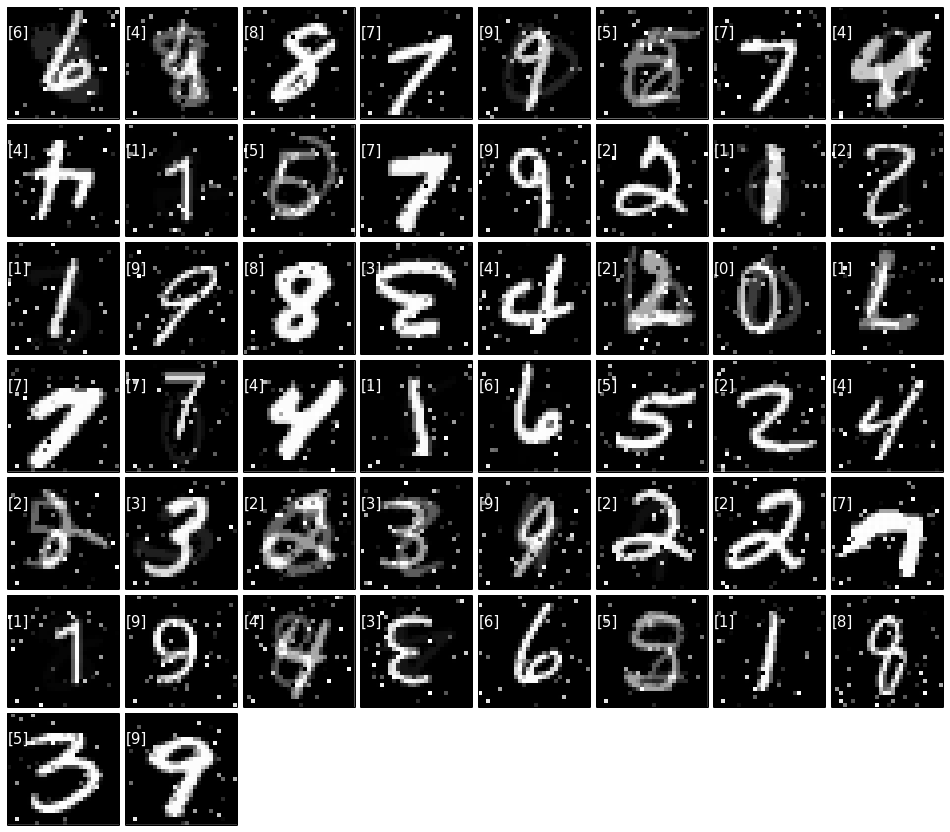

In [5]:
digits = [new_dtrain[i].reshape(28, 28) for i in range (50)]
labels = new_dlabels[:50]

plot = digits_plot(digits, labels)

plot.show()

Изначально функция noise reduction предполагалась мной для использования в качестве фукнции уберающей некоторые шумы на картинке. Под шумами я предполагал пиксели, которые не несут информации о цифре. (одиночные пиксели разбросанные по картинке целиком, либо остатки после того, как мы что-то стерли) Однако потом я много модифицировал функцию и начал выделять конкретные признаки, а на шумовые(в том понимании, в котором я говорил) я не обращал внимание. Это позволило мне сделать цифры более жирными и яркими.

In [6]:
def noise_reduction(data_set):
    zero_noisy = []
    for i in range(len(data_set)):
        noisy_image = data_set[i][0]
        noise = np.random.random(noisy_image.shape)
        noisy_image[noisy_image > 190] = 170

        zero_noisy.append(noisy_image)
    return(zero_noisy)


def knn_algorithm(X_train, y_train, X_test, y_test, **kargs):
    start = time.time()
    model = KNeighborsClassifier(**kargs)
    model.fit(X_train, y_train)
    fraction_misclassifications = zero_one_loss(y_test, model.predict(X_test))
    end = time.time()
    return(fraction_misclassifications, end-start)

Сделаем копию обучающей выборки. Это необходимо по той причине, что noise_reduction модифицирует объект, так как он передается по ссылке.

In [7]:
data_set = new_dtrain[:]
data_set_labels = new_dlabels[:]

Чистим шумы на картинки и выводим результат. Сравнивая с предыдущей таблицей. Результат чувствуется.

P.S. Сначала я пробовал избавиться от шума, но это не помогло. Затем я начал выделять те участки и пиксели, Которые мне казались самыми важными. Это позволило сделать цифры ярче и жирнее.

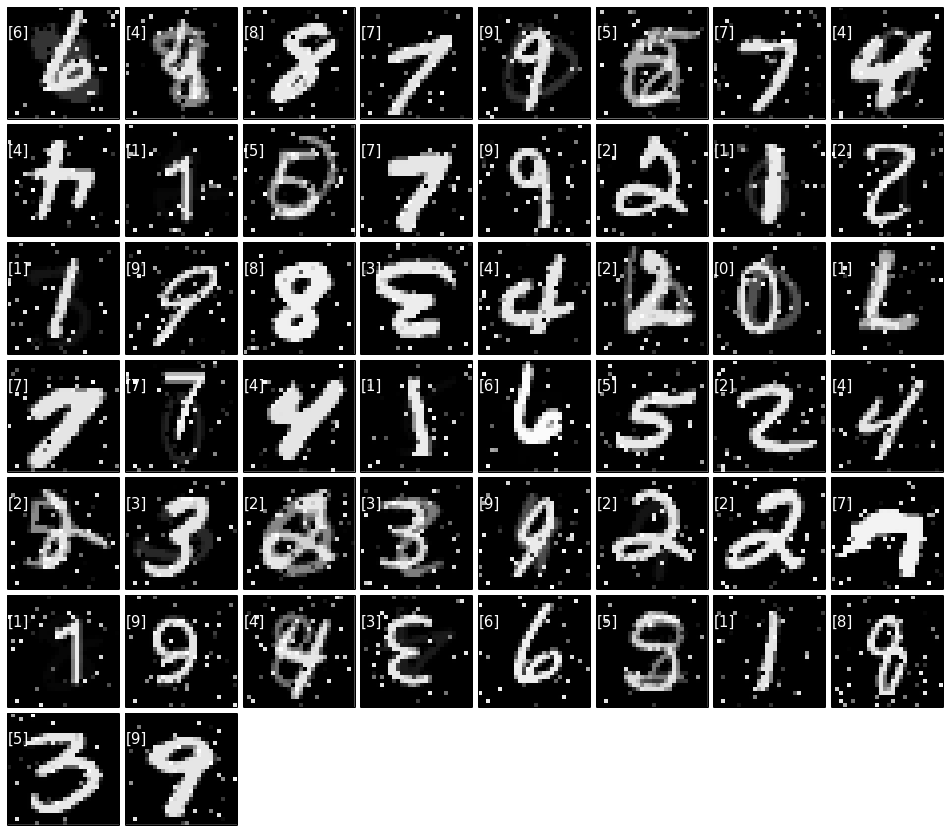

In [8]:
data_set = data_set.reshape((-1, 1, 28, 28)).astype(np.uint8)
data_without_noise = noise_reduction(data_set)

plt = digits_plot(data_without_noise[:50], data_set_labels[:50])
plt.show()


Здесь сохраняем полученные новые картинки.

In [9]:
new_d = [data_without_noise[i].ravel() for i in range((50000))]


In [18]:
pd.DataFrame(new_d).to_csv("new_train50000.txt", sep=' ', index=False, header=False, mode='a')

Опробуем нашу гипотезу об улчшении качества после устранения шума. Причем рассмотри три варианта. 1) Шум убираем
и на тестовой и на обучающей выборках. 2) Убираем шум только на тестовой выборке. 3) Убираем шум с обучающей выборке, а на тестовой оставляем. И прогоняем 8NN на нескольких обучающих выборках, при этои размер тестовой фиксирован.

P.S.
Сначала я убирал шумы, но потом делал то, что описывал выше. Это значительно улучшило качество на валидационной выборке.(на около 3.5% в среднем)

In [11]:
for i in range(5):
    test_start = 5000 + i*1000
    test_end = test_start + 1000
    train_with_noise = np.array(new_dtrain[:test_start]).reshape(-1, 784)
    test_with_noise = np.array(new_dtrain[18000:20000]).reshape(-1, 784)
    result = knn_algorithm(train_with_noise, new_dlabels[:test_start], test_with_noise, 
                           new_dlabels[18000:20000], n_neighbors=8, algorithm='brute')
    print(result[0])

0.16
0.152
0.146
0.1445
0.142


In [12]:
for i in range(5):
    test_start = 5000 + i*1000
    test_end = test_start + 1000
    train_without_noise = np.array(data_without_noise[:test_start]).reshape(-1, 784)
    test_without_noise = np.array(data_without_noise[18000:20000]).reshape(-1, 784)
    result = knn_algorithm(train_without_noise, new_dlabels[:test_start], test_without_noise, 
                           new_dlabels[18000:20000], n_neighbors=8, algorithm='brute')
    print(result[0])

0.1325
0.1285
0.125
0.1215
0.1195


In [23]:
for i in range(5):
    test_start = 5000 + i*1000
    test_end = test_start + 1000
    train_without_noise = np.array(data_without_noise[:test_start]).reshape(-1, 784)
    test_with_noise = np.array(new_dtrain[16000:20000]).reshape(-1, 784)
    result = knn_algorithm(train_without_noise, new_dlabels[:test_start], test_with_noise, 
                           new_dlabels[16000:20000], n_neighbors=8, algorithm='brute')
    print(result[0])

0.11825
0.1135
0.11075
0.10725
0.1015


In [494]:
for i in range(5):
    test_start = 5000 + i*1000
    test_end = test_start + 1000
    train_without_noise = np.array(data_without_noise[:test_start]).reshape(-1, 784)
    test_with_noise = np.array(new_dtrain[test_start:test_end]).reshape(-1, 784)
    result = knn_algorithm(train_without_noise, new_dlabels[:test_start], test_with_noise, 
                           new_dlabels[test_start:test_end], n_neighbors=8, algorithm='brute')
    print(result[0])
    
#noisy_image[noisy_image > 190] = 170 9.5

0.122
0.114
0.137
0.113
0.095


In [305]:
for i in range(5):
    test_start = 5000 + i*1000
    test_end = test_start + 1000
    train_with_noise = np.array(new_dtrain[:test_start]).reshape(-1, 784)
    test_without_noise = np.array(data_without_noise[test_start:test_end]).reshape(-1, 784)
    result = knn_algorithm(train_with_noise, new_dlabels[:test_start], test_without_noise, 
                           new_dlabels[test_start:test_end], n_neighbors=8, algorithm='brute')
    print(result[0])

0.71
0.747
0.723
0.7
0.662


Итак, в среднем самые лучшие результаты достигаются на выборке без шума. Поэтому Такая модификация признаков не помогла. В таком случае, попробуем посмотреть матрицу ошибок дабы понять нам при распознавании каких цифр мы делаем чаще всего ошибки. Попробуем посмотреть на матрицу после преобразований.

In [19]:
test_start = 5000
test_end = 6000
train_without_noise = np.array(data_without_noise[:test_start]).reshape(-1, 784)
test_with_noise = np.array(new_dtrain[test_start:test_end]).reshape(-1, 784)
model = KNeighborsClassifier(n_neighbors=8, algorithm='brute')
model.fit(train_without_noise, new_dlabels[:test_start])
confusion_matrix(new_dlabels[test_start:test_end], model.predict(test_with_noise) )

array([[ 99,   0,   1,   0,   0,   1,   0,   0,   1,   0],
       [  0, 109,   1,   0,   0,   1,   2,   0,   0,   0],
       [  5,   4,  74,   1,   2,   0,   1,   2,   0,   2],
       [  2,   1,   1,  94,   0,   1,   1,   2,   2,   2],
       [  2,   3,   0,   0,  58,   0,   2,   4,   0,   6],
       [  4,   5,   0,   7,   2,  74,   4,   0,   2,   4],
       [  0,   2,   0,   0,   0,   1,  92,   0,   1,   1],
       [  1,   1,   1,   2,   0,   0,   0,  89,   0,   1],
       [  1,   4,   1,   4,   0,   1,   4,   0,  88,   3],
       [  1,   2,   1,   3,   3,   0,   1,   1,   0, 101]])

Итак, в среднем самые лучшие результаты достигаются на выборке без шума. Поэтому Такая модификация признаков не помогла. В таком случае, попробуем посмотреть матрицу ошибок дабы понять нам при распознавании каких цифр мы делаем чаще всего ошибки. Попробуем посмотреть на матрицу допреобразований.

In [20]:
test_start = 5000
test_end = 6000
train_with_noise = np.array(new_dtrain[:test_start]).reshape(-1, 784)
test_with_noise = np.array(new_dtrain[test_start:test_end]).reshape(-1, 784)
model = KNeighborsClassifier(n_neighbors=8, algorithm='brute')
model.fit(train_with_noise, new_dlabels[:test_start])
confusion_matrix(new_dlabels[test_start:test_end], model.predict(test_with_noise) )

array([[ 98,   0,   1,   1,   0,   0,   0,   0,   1,   1],
       [  0, 112,   0,   0,   0,   0,   1,   0,   0,   0],
       [  4,   6,  72,   2,   1,   0,   2,   2,   0,   2],
       [  2,   1,   1,  93,   0,   2,   2,   3,   0,   2],
       [  1,   4,   0,   0,  62,   1,   1,   1,   0,   5],
       [  5,   8,   0,   7,   2,  74,   1,   0,   2,   3],
       [  2,   4,   0,   0,   0,   1,  89,   0,   0,   1],
       [  2,   3,   1,   2,   0,   0,   0,  86,   0,   1],
       [  1,   8,   2,   5,   1,   3,   4,   1,  78,   3],
       [  1,   3,   0,   2,   4,   0,   1,   4,   0,  98]])

Видно, что после наших преобразований мы побороли ошибку при очень высокой неверной классификации пятерки и восьмерки.

Теперь сделаем это преобразование для тестовой выборке. И посмотрим, что получится.

In [9]:
data_set = dtest[:]

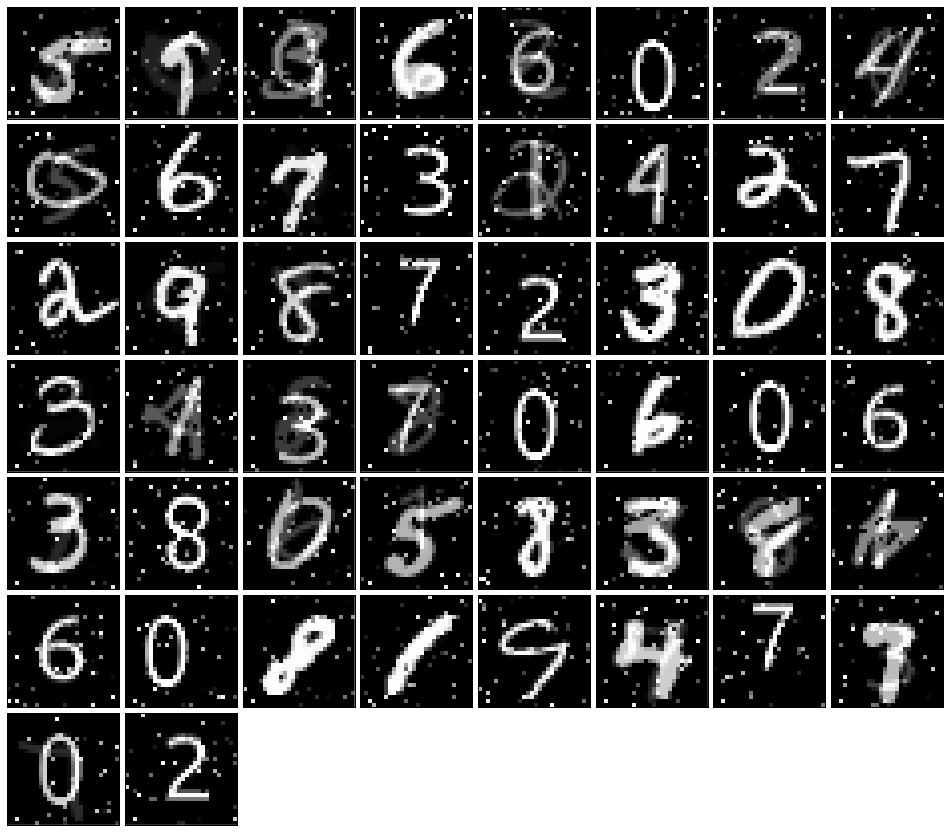

In [10]:
digits = [dtest[i].reshape(28, 28) for i in range (50)]

plt = digits_plot(digits)
plt.show()


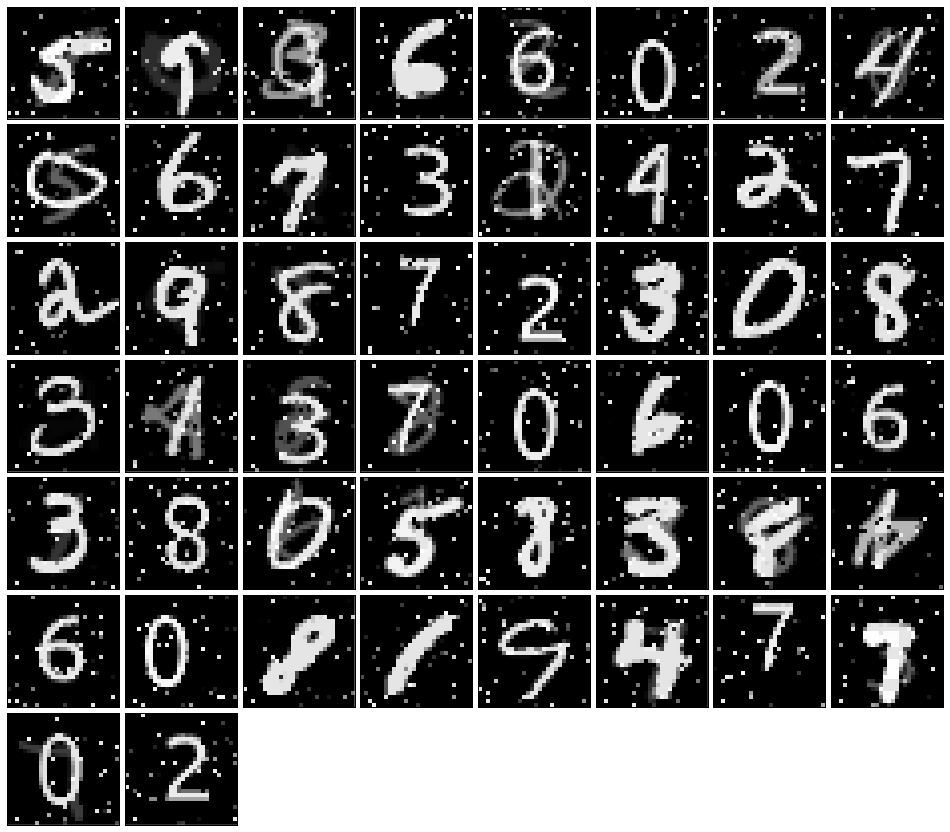

In [11]:
data_set = data_set.reshape((-1, 1, 28, 28)).astype(np.uint8)
data_without_noise = noise_reduction(data_set)

plt = digits_plot(data_without_noise[:50])
plt.show()


Но как мы установили выше, лучше тестовую выборку не трогать. Поэтому оставим ее впокое и попробуем запустить 9NN, на обучающей выборке в 50000 картинок. Он пока что считается. Потом увидим результат.

In [23]:

X_train = np.array(pd.read_csv("new_train50000.txt", header=None, sep='\\s+'))


In [25]:
y_train = new_dlabels[:50000]
model = KNeighborsClassifier(n_neighbors=9, algorithm='brute')
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [ ]:
predictions = model.predict(dtest)

In [ ]:
final_data = [(i, int(predictions[i])) for i in range(20000) ]

pd.DataFrame(final_data).to_csv("final_predictions4.csv", sep=',', index=False, header=False, mode='a')

In [ ]:
final_data = [(i, predictions[i]) for i in range(20000)]
pd.DataFrame(final_data).to_csv("new_predictions.csv", index=False, header=False, mode='a')

Таким образом, мы модицифировали признаки, выделив те, которые пиксели, которые более имформативны. Так же в функции reduction_noise я пробовал окинуть некоторые шумовые признаки. Таким образом уменьшить размерность. Под шумом я понимал те, которые на картинке малоинформативны и выглядят как разброс точек. Либо остатки от цифры, которая была здесь на этом месте написана ранее, а потом стерта. Однако заметного результата это не принесло. И даже наоборот потеря части признаков ухудшило качество.